# Exploring London, the Big Ben city

## Introduction
The aim of the project is to identify and analyze places in London based on average prices and rating. In this notebook, we will identify various venues in the city of London to help customers select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

### A little more about London
London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans.

The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits. The City of Westminster is also an Inner London borough holding city status. Greater London is governed by the Mayor of London and the London Assembly.

London is considered to be one of the world's most important global cities and has been termed the world's most powerful, most desirable, most influential, most visited, most expensive, innovative, sustainable, most investment friendly, and most popular for work city in the world. London exerts a considerable impact upon the arts, commerce, education, entertainment, fashion, finance, healthcare, media, professional services, research and development, tourism and transportation. London ranks 26 out of 300 major cities for economic performance. It is one of the largest financial centres and has either the fifth or sixth largest metropolitan area GDP. It is the most-visited city as measured by international arrivals and has the busiest city airport system as measured by passenger traffic.

In [18]:
LD_LATITUDE = 51.50986
LD_LONGITUDE = -0.118092
print('The geograpical coordinates of London are {}, {}.'.format(LD_LATITUDE, LD_LONGITUDE))

The geograpical coordinates of London are 51.50986, -0.118092.


In [19]:
##Creating a London map
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

ld_map = folium.Map(location = [LD_LATITUDE, LD_LONGITUDE], zoom_start = 10)
folium.Marker([LD_LATITUDE, LD_LONGITUDE]).add_to(ld_map)
ld_map

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         868 KB

The following NEW packages will be INSTALLED:

    altair:  3.2.0-py36_0 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


altair-3.2.0         | 770 KB    | #################################

## Data that will be used
In this section we will configure the Foursquare API and the Zomato API, that is a popular platform in London to see ratings and other informations.

In [20]:
FOURSQUARE_CLIENT_ID = '22ICIZCDAVBEMVZCJWDNV15DSJNKILQCTH3P3SN4MP3X2MAC'
FOURSQUARE_CLIENT_SECRET = 'UYOQ2IYGVROAWXB2PQWGV225VBZAPWPQKFO2AWSG40GG5ALD'
RADIUS = 3000 #SPECIFYING 3 KM
NO_OF_VENUES = 80
VERSION = '20191016' # Current date

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        LD_LATITUDE, 
                                                                        LD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 80 venues fetched within a total radius of 3.0 Km

Total 80 venues fetched


In [21]:
## Configuring ZOMATO API
#The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

#We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

#The query will be the name of the venue.
#The start defines from what offset we want to start, so we'll keep it at 0.
#The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
#We will supply the latitude and longitude values.
#We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

headers = {'user-key': '01a1d975fe585f4c3ec664b163ef6e44'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
    zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [22]:
##Data cleaning and foursquare data validation

ld_map = folium.Map(location = [LD_LATITUDE, LD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(ld_map)  
    
ld_map

Combining the foursquare and ZOMATO datasets

In [23]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']


selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Lyceum Theatre,Theater,51.5116,-0.1198,Lyceum Tavern,51.5113,-0.1197,35,2,3.3,"354 Strand, Covent Garden, London WC2R 0HS",-0.0003,0.0001
1,The Savoy Hotel,Hotel,51.5104,-0.1209,The Lounge Bar - The Strand Palace Hotel,51.5107,-0.1210,50,3,3.3,"The Strand Palace Hotel, 372 Strand, Strand, L...",0.0003,-0.0001
2,National Theatre,Theater,51.5074,-0.1148,National Theatre Espresso Bar,51.5071,-0.1149,15,1,3.3,"National Theatre, South Bank, London SE1 9PX",-0.0003,-0.0001
3,SUSHISAMBA Covent Garden,Sushi Restaurant,51.5122,-0.1224,Pisco Bar @ LIMA Floral,51.5121,-0.1224,45,3,0,"14 Garrick Street, Covent Garden, London WC2E 9BJ",-0.0001,0.0000
4,Covent Garden Market,Shopping Plaza,51.5120,-0.1228,Ladurée,51.5121,-0.1228,65,3,4.7,"1 The Market, Covent Garden, London WC2E 8RA",0.0001,0.0000
5,Gordon's Wine Bar,Wine Bar,51.5079,-0.1233,Gordon's Wine Bar,51.5079,-0.1235,50,3,4.7,"47 Villiers Street, Strand, London WC2N 6NE",0.0000,-0.0002
6,Sticks'n'Sushi,Sushi Restaurant,51.5110,-0.1237,Sticks 'n' Sushi,51.5112,-0.1236,65,3,4.8,"11 Henrietta Street, Covent Garden, London WC2...",0.0002,0.0001
7,Flat Iron,Steakhouse,51.5108,-0.1241,Flat Iron,51.5108,-0.1240,35,2,4.8,"17-18 Henrietta Street, Covent Garden, London ...",0.0000,0.0001
8,Ladurée,Dessert Shop,51.5120,-0.1233,Creme De La Crepe,51.5121,-0.1230,20,2,4.1,"Unit 29, The Piazza, Covent Garden, London WC2...",0.0001,0.0003
9,Southbank Centre,Performing Arts Venue,51.5058,-0.1170,Feng Sushi,51.5058,-0.1168,35,2,3.6,"Unit 9, Festival Terrace, South Bank Centre, B...",0.0000,0.0002


Adding the price information

In [24]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])
selected_venues.head(10)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Theater,Lyceum Tavern,51.5113,-0.1197,2,3.3,"354 Strand, Covent Garden, London WC2R 0HS",17.5
1,Hotel,The Lounge Bar - The Strand Palace Hotel,51.5107,-0.1210,3,3.3,"The Strand Palace Hotel, 372 Strand, Strand, L...",25.0
2,Theater,National Theatre Espresso Bar,51.5071,-0.1149,1,3.3,"National Theatre, South Bank, London SE1 9PX",7.5
3,Sushi Restaurant,Pisco Bar @ LIMA Floral,51.5121,-0.1224,3,0,"14 Garrick Street, Covent Garden, London WC2E 9BJ",22.5
4,Shopping Plaza,Ladurée,51.5121,-0.1228,3,4.7,"1 The Market, Covent Garden, London WC2E 8RA",32.5
5,Wine Bar,Gordon's Wine Bar,51.5079,-0.1235,3,4.7,"47 Villiers Street, Strand, London WC2N 6NE",25.0
6,Sushi Restaurant,Sticks 'n' Sushi,51.5112,-0.1236,3,4.8,"11 Henrietta Street, Covent Garden, London WC2...",32.5
7,Steakhouse,Flat Iron,51.5108,-0.1240,2,4.8,"17-18 Henrietta Street, Covent Garden, London ...",17.5
8,Dessert Shop,Creme De La Crepe,51.5121,-0.1230,2,4.1,"Unit 29, The Piazza, Covent Garden, London WC2...",10.0
9,Performing Arts Venue,Feng Sushi,51.5058,-0.1168,2,3.6,"Unit 9, Festival Terrace, South Bank Centre, B...",17.5


Here we can see that there is a lot of restaurants over 15 in the average price.

But we need to exclude the rating 0 places, that is probably new

In [25]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 36


## Methodology section

We will aim at identifying the venues in London based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference. As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of London, upto a distance of 3 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

After, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue. Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

#### Analyzing the places category

<BarContainer object of 24 artists>

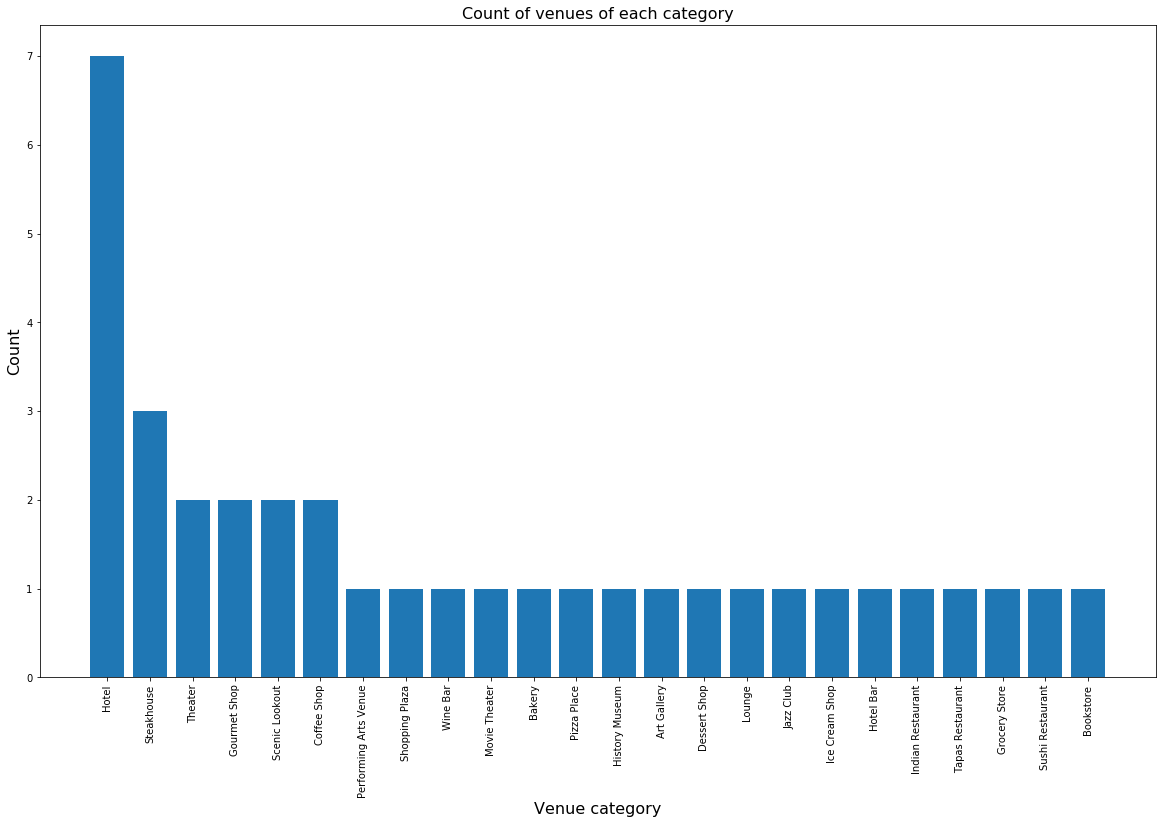

In [26]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values)

We can conclude that the majority venues are Cafe and Indian Restaurant

#### Analyzing the rates

Text(0.5, 1.0, 'Count of venues with given rating')

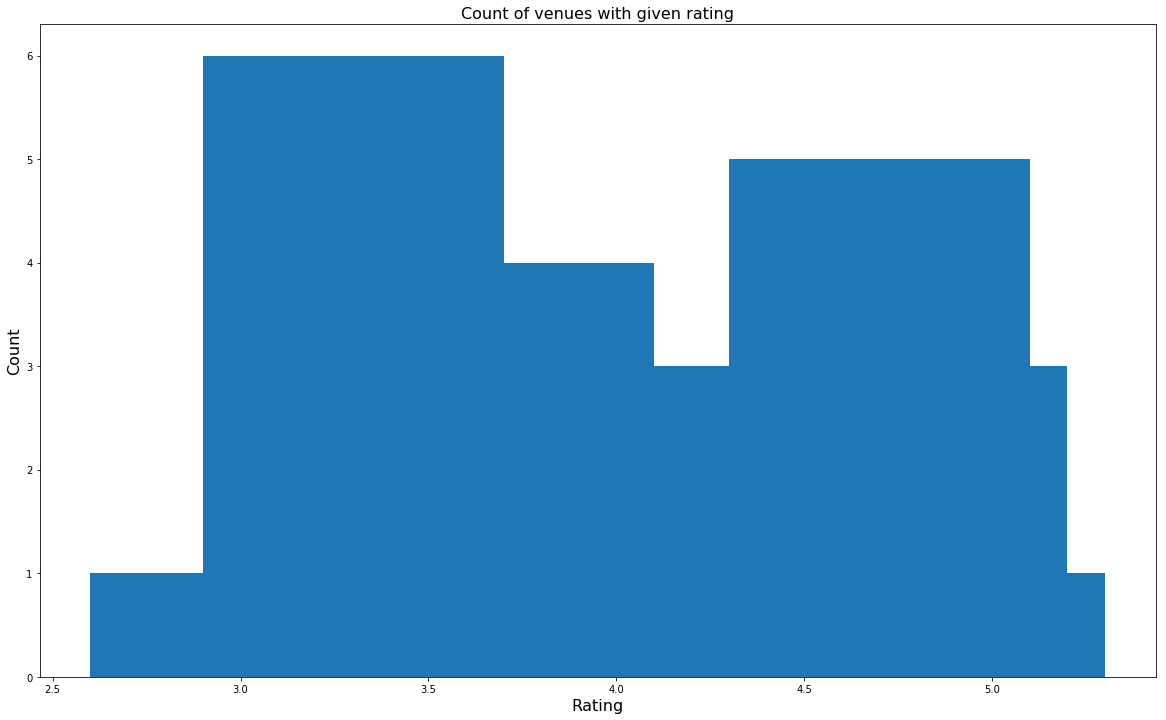

In [27]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values)
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

Here we can see that the majority of ratings is between 3 and 5

Now let's create some categories:
2 to 3
3 to 4
4 to 5
5 to 6

In [28]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

And now let's add it into the map

In [29]:
color_map = {'Low': 'red', 'Okay': 'yellow', 'Good': 'green', 'Very good': 'blue'}

ld_map = folium.Map(location = [LD_LATITUDE, LD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(ld_map)  

ld_map


Here we can conclude that the best places are in the left side of the bridge (to the west). More specifically at the Covent Garden neighborhood.

#### Now we will do the clusters

In [30]:

from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Theater,Lyceum Tavern,51.5113,-0.1197,2,3.3,"354 Strand, Covent Garden, London WC2R 0HS",17.5,Good
1,1,Hotel,The Lounge Bar - The Strand Palace Hotel,51.5107,-0.1210,3,3.3,"The Strand Palace Hotel, 372 Strand, Strand, L...",25.0,Good
2,0,Theater,National Theatre Espresso Bar,51.5071,-0.1149,1,3.3,"National Theatre, South Bank, London SE1 9PX",7.5,Good
4,1,Shopping Plaza,Ladurée,51.5121,-0.1228,3,4.7,"1 The Market, Covent Garden, London WC2E 8RA",32.5,Very good
5,1,Wine Bar,Gordon's Wine Bar,51.5079,-0.1235,3,4.7,"47 Villiers Street, Strand, London WC2N 6NE",25.0,Very good


And then analyze this two clusters

In [31]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Theater,Lyceum Tavern,51.5113,-0.1197,2,3.3,"354 Strand, Covent Garden, London WC2R 0HS",17.5,Good
1,0,Theater,National Theatre Espresso Bar,51.5071,-0.1149,1,3.3,"National Theatre, South Bank, London SE1 9PX",7.5,Good
2,0,Steakhouse,Flat Iron,51.5108,-0.1240,2,4.8,"17-18 Henrietta Street, Covent Garden, London ...",17.5,Very good
3,0,Dessert Shop,Creme De La Crepe,51.5121,-0.1230,2,4.1,"Unit 29, The Piazza, Covent Garden, London WC2...",10.0,Very good
4,0,Performing Arts Venue,Feng Sushi,51.5058,-0.1168,2,3.6,"Unit 9, Festival Terrace, South Bank Centre, B...",17.5,Good
5,0,Ice Cream Shop,Amorino,51.5115,-0.1259,2,4.7,"7 Garrick Street, Covent Garden, London WC2E 9AR",10.0,Very good
6,0,Indian Restaurant,Dishoom,51.5124,-0.1272,2,4.9,"12 Upper St Martin's Lane, Covent Garden, Lond...",17.5,Very good
7,0,Art Gallery,The Portrait Cafe,51.5094,-0.1281,1,3.3,"National Portrait Gallery, 2 St Martin's Place...",7.5,Good
8,0,Scenic Lookout,The County Hall Arms,51.5033,-0.1196,2,3.6,"County Hall, Riverside Building, Westminster B...",15.0,Good
9,0,Coffee Shop,Monmouth Coffee Company,51.5144,-0.1268,1,4.6,"27 Monmouth Street, Covent Garden, London WC2H...",7.5,Very good


In [32]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.56 and rating spread around 3.94


Cluster 1

In [33]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,The Lounge Bar - The Strand Palace Hotel,51.5107,-0.1210,3,3.3,"The Strand Palace Hotel, 372 Strand, Strand, L...",25.0,Good
1,1,Shopping Plaza,Ladurée,51.5121,-0.1228,3,4.7,"1 The Market, Covent Garden, London WC2E 8RA",32.5,Very good
2,1,Wine Bar,Gordon's Wine Bar,51.5079,-0.1235,3,4.7,"47 Villiers Street, Strand, London WC2N 6NE",25.0,Very good
3,1,Sushi Restaurant,Sticks 'n' Sushi,51.5112,-0.1236,3,4.8,"11 Henrietta Street, Covent Garden, London WC2...",32.5,Very good
4,1,Movie Theater,Benugo Bar & Kitchen,51.5049,-0.1137,3,3.7,"BFI Southbank, Waterloo, London SE1 8XT",30.0,Good
5,1,Steakhouse,Hawksmoor Seven Dials,51.5134,-0.1257,4,4.7,"11 Langley Street, Covent Garden, London WC2H 9JG",37.5,Very good
6,1,Hotel,Chambers Restaurant - Apex Temple Court Hotel,51.5136,-0.1087,4,3.4,"Apex Temple Court Hotel, 1-2 Serjeants' Inn, F...",40.0,Good
7,1,Hotel,Rumpus Room - Mondrian London,51.5080,-0.1070,3,3.5,"Mondrian London, 20 Upper Ground, South Bank, ...",25.0,Good
8,1,Hotel,Mirror Room - Rosewood Hotel,51.5174,-0.1179,3,3.9,"Rosewood Hotel, 252 High Holborn, Holborn, Lon...",30.0,Good
9,1,Hotel Bar,Scarfes Bar - Rosewood Hotel,51.5174,-0.1179,3,3.9,"Rosewood Hotel, 252 High Holborn, Holborn, Lon...",22.5,Good


In [34]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.22 and rating spread around 4.00


## Results and discussions

## Conclusions:
The main goal of the project was explore London venues. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The analysis finish with two clusters considering rating and price, so you can choose the best place to go to get a nice and not so expensive place.

And we can conclude that the cluster 0 has 